## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os

# something to solve error kept happening source: https://markhneedham.com/blog/2019/05/10/jupyter-runtimeerror-this-event-loop-is-already-running/
import nest_asyncio 
nest_asyncio.apply()


%matplotlib inline
sns.set()

# %run  ./data_cleaning_part02.ipynb

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Loading Cleaned Data

In [2]:
full_table = pd.read_csv('./cleaned_data/daily_disagg.csv', parse_dates=['date'])
full_table.set_index(['country', 'state', 'date'], inplace=True)
full_cleaned_country = pd.read_csv('./cleaned_data/per_country_aggregate.csv')
full_wom_country = pd.read_csv('./cleaned_data/allcountries_worldometer.csv')
display('full_table.head()', 'full_cleaned_country.head()', 'full_wom_country.head()')

full_table.head()
                                   continent  confirmed  deaths  recovered  \
country     state       date                                                 
Afghanistan Afghanistan 2020-02-24    Others        1.0     0.0        0.0   
                        2020-03-08    Others        3.0     0.0        0.0   
                        2020-03-10    Others        1.0     0.0        0.0   
                        2020-03-11    Others        2.0     0.0        0.0   
                        2020-03-14    Others        4.0     0.0        0.0   

                                    active  tests  
country     state       date                       
Afghanistan Afghanistan 2020-02-24     0.0    NaN  
                        2020-03-08     0.0    NaN  
                        2020-03-10     0.0    NaN  
                        2020-03-11     0.0    NaN  
                        2020-03-14     0.0    NaN  

full_cleaned_country.head()
  continent      country  confirmed  deaths  recovered   active
0    Others  Afghanistan   151770.0  7000.0        0.0   5996.5
1    Others      Albania   135947.0  2464.0        0.0   3850.0
2    Others      Algeria   187258.0  4794.0        0.0  20072.0
3    Others      Andorra    14924.0   129.0        0.0    335.0
4    Others       Angola    44617.0  1100.0        0.0   1451.5

full_wom_country.head()
  continent      country  confirmed  deaths  recovered   active     tests  \
0      Asia  Afghanistan     152243  7031.0   107032.0  38180.0  745689.0   
1    Europe      Albania     136147  2466.0   130700.0   2981.0  966587.0   
2    Africa      Algeria     187968  4830.0   126661.0  56477.0  230861.0   
3    Europe      Andorra      14954   129.0    14673.0    152.0  193595.0   
4    Africa       Angola      44739  1103.0    41573.0   2063.0  821071.0   

   population  
0  39909905.0  
1   2874263.0  
2  44738446.0  
3     77404.0  
4  34008725.0

## Functions
* hbar_plot: plot stacked bars plot 

In [3]:
def hbar_plot(df, cols_to_colors):
    fig, ax = plt.subplots(figsize=(12,10))
    for col, color in cols_to_colors.items():
        df[col].plot(ax=ax, kind='barh', color=color, label=f'{col.title()}')
        ax.set_xlabel('Number of cases', labelpad=20)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:12,.0f}'.format(x)))
        ax.set_ylabel('')
        ax.legend()

## continents
* using worldometer data

In [4]:
xs_continents = full_wom_country.groupby('continent').sum().sort_values('confirmed', ascending=False)
# total row
total = xs_continents.sum()
total.name = 'Total'
xs_continents = xs_continents.append(total)
# confirmed per 100 pop
xs_continents['confirmed per 100'] = 100*xs_continents['confirmed']/xs_continents['population']
# Mortality per 100
xs_continents['mortaliy per 100'] = 100*xs_continents['deaths']/xs_continents['confirmed']
# Tests per 100 of pop
xs_continents['tests per 100'] = 100*xs_continents['tests']/xs_continents['population']
# style
xs_continents.style\
    .format('{:0.2f}', subset=['confirmed per 100', 'mortaliy per 100', 'tests per 100'])\
    .format('{:12,.0f}', subset=xs_continents.columns[:-3])\
    .background_gradient(cmap='Greens', low=0, high=0.5, 
    subset=(xs_continents.index[:-1], xs_continents.columns[:]))\
    .background_gradient(cmap='Oranges',
     subset=(xs_continents.index[-1], xs_continents.columns[:])) 
     # using pd.IndexSlice is just a wrapper to make tuples of slice(),...

,confirmed,deaths,recovered,active,tests,population,confirmed per 100,mortaliy per 100,tests per 100
continent,,,,,,,,,
Asia,"66,304,847","970,627","61,689,892","3,644,328","1,159,815,975","4,647,559,477",1.43,1.46,24.96
Europe,"53,422,814","1,151,768","48,373,269","3,897,777","1,131,643,341","748,137,962",7.14,2.16,151.26
North America,"45,163,309","961,876","36,421,359","7,780,074","628,862,638","594,291,368",7.60,2.13,105.82
South America,"36,320,764","1,112,871","32,330,878","940,596","148,823,504","434,749,746",8.35,3.06,34.23
Africa,"7,360,189","184,831","6,463,413","711,945","63,179,033","1,376,515,395",0.53,2.51,4.59
Australia/Oceania,"132,557","1,798","93,533","37,226","31,540,658","42,853,818",0.31,1.36,73.60
Total,"208,704,480","4,383,771","185,372,344","17,011,946","3,163,865,149","7,844,107,766",2.66,2.10,40.33


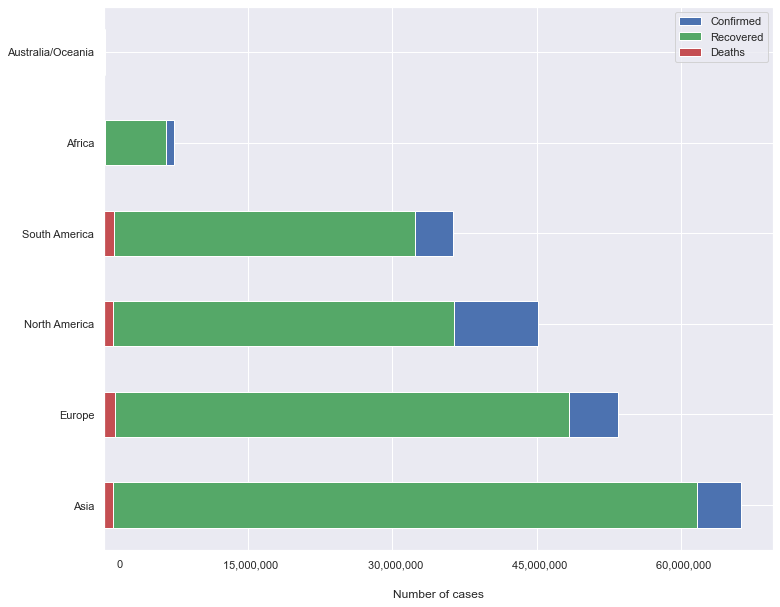

In [5]:
hbar_plot(xs_continents[:-1], {'confirmed':'b', 'recovered':'g', 'deaths':'r'});

## All Countries
* using Worldometer

In [6]:
xs_countries = full_wom_country.copy().drop(columns='continent')
xs_countries = xs_countries.set_index('country').sort_values('confirmed', ascending=False)

# Cases per 100
xs_countries['cases % of pop'] = 100*xs_countries['confirmed']/xs_countries['population']
# Mortality per 100 cases
xs_countries['mortaliy % of cases'] = 100*xs_countries['deaths']/xs_countries['confirmed']
# Tests per 100 of pop
xs_countries['tests % of pop'] = 100*xs_countries['tests']/xs_countries['population']
xs_countries)
# style
xs_countries.sort_values('active', ascending=False).head(10).style\
    .format('{:^0.2f}', na_rep='-', subset=['cases % of pop', 'mortaliy % of cases', 'tests % of pop'])\
    .format('{:20,.0f}', na_rep='-', subset=xs_countries.columns[:-3])\
    .background_gradient(cmap='Greens', low=0, high=0.5)\
    .highlight_null('#265431')

,confirmed,deaths,recovered,active,tests,population,cases % of pop,mortaliy % of cases,tests % of pop
country,,,,,,,,,
USA,"37,736,986","638,798","30,227,302","6,870,886","558,144,828","333,183,130",11.33,1.69,167.52
UK,"6,295,613","130,979","4,856,841","1,307,793","257,623,937","68,286,659",9.22,2.08,377.27
Spain,"4,719,266","82,595","3,986,567","650,104","59,650,532","46,775,140",10.09,1.75,127.53
Iran,"4,467,015","98,483","3,757,157","611,375","27,177,565","85,199,097",5.24,2.20,31.90
Brazil,"20,378,986","569,581","19,255,927","553,478","56,023,684","214,256,441",9.51,2.79,26.15
Russia,"6,621,601","171,305","5,899,917","550,379","172,500,000","146,004,820",4.54,2.59,118.15
France,"6,476,864","112,753","5,913,362","450,749","111,773,788","65,435,866",9.90,1.74,170.81
Turkey,"6,096,816","53,324","5,621,646","421,846","72,091,836","85,357,657",7.14,0.87,84.46
Mexico,"3,108,438","248,652","2,454,114","405,672","9,113,592","130,453,223",2.38,8.00,6.99


## World map: confirmed cases
* crashes the notebook

In [7]:
# temp_df = pd.DataFrame(xs_countries['confirmed'])
# temp_df = temp_df.reset_index()
# fig = px.choropleth(temp_df, locations="country",
#                     color=np.log10(temp_df["confirmed"]), # lifeExp is a column of gapminder
#                     hover_name="country", # column to add to hover information
#                     hover_data=["confirmed"],
#                     color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
# fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Blues")
# # fig.to_image("Global Heat Map confirmed.png")
# fig.show()

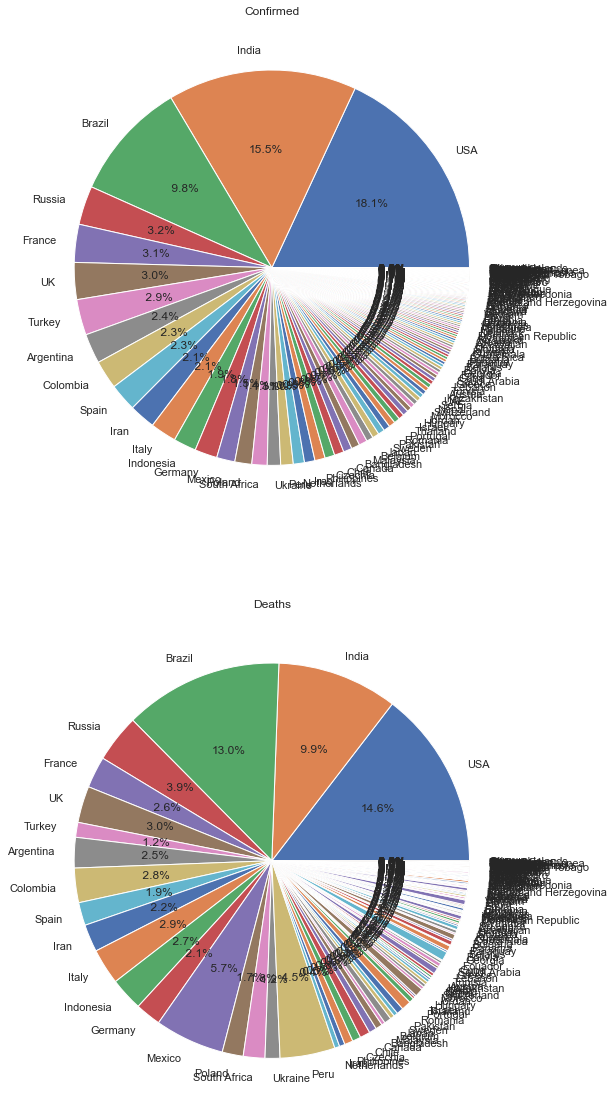

In [8]:
# for pie better to group countries with small number of cases
df_temp = xs_countries.copy()
# summing up countries with less than 10000 cases
filt = df_temp['confirmed'] < 10000
low_cases_cntrs = df_temp[filt].sum()
df_temp = df_temp[~ filt]
low_cases_cntrs.name = 'Others'
df_temp = df_temp.append(low_cases_cntrs)

fig, ax = plt.subplots(2,1, figsize=(30,20))
df_temp['confirmed'].plot(ax= ax[0], kind='pie', autopct='%4.1f%%', title='Confirmed');
df_temp['deaths'].plot(ax= ax[1], kind='pie', autopct='%4.1f%%', title='Deaths');
ax[0].set_xlabel('')
ax[0].set_ylabel('');
ax[1].set_xlabel('')
ax[1].set_ylabel('');

# Miscellaneous

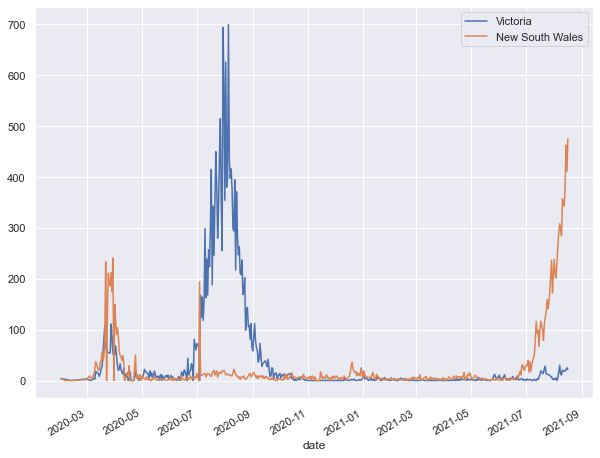

In [17]:
# the wave seems serious (Victoria's 10 largest daily increases happened in July)
vic = full_table.loc[('Australia', 'Victoria')]
nsw = full_table.loc[('Australia', 'New South Wales')]
#full_table.loc[full_table.loc[('Australia', 'Victoria'), 'confirmed'].nlargest(10).index]
#vic.loc[vic['confirmed'].nlargest(10).index]
fig, ax = plt.subplots(figsize=(10,8))
vic['confirmed'].plot(ax=ax, label='Victoria')
nsw['confirmed'].plot(ax=ax, label='New South Wales')
ax.legend();

In [18]:
vic['avg5'] = vic.rolling(window=5).agg('mean')['confirmed']
vic.tail(n=20)

<ipython-input-18-92df3c3755ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vic['avg5'] = vic.rolling(window=5).agg('mean')['confirmed']


,continent,confirmed,deaths,recovered,active,tests,avg5
date,,,,,,,
2021-07-27,Others,10.0,0.0,2.0,198.0,NaN,11.8
2021-07-28,Others,8.0,0.0,1.0,205.0,NaN,10.6
2021-07-29,Others,7.0,0.0,7.0,205.0,NaN,9.6
2021-07-30,Others,3.0,0.0,8.0,200.0,NaN,7.8
2021-07-31,Others,2.0,0.0,22.0,180.0,NaN,6.0
2021-08-01,Others,4.0,0.0,23.0,161.0,NaN,4.8
2021-08-02,Others,2.0,0.0,29.0,134.0,NaN,3.6
2021-08-03,Others,5.0,0.0,15.0,124.0,NaN,3.2
2021-08-04,Others,0.0,0.0,25.0,99.0,NaN,2.6


In [11]:
Aus = full_table.loc['Australia']
Aus.reorder_levels(['date', 'state']).sort_index().tail(100)

continent  confirmed  deaths  \
date       state                                                       
2021-08-03 Northern Territory              Others        0.0     0.0   
           Queensland                      Others       16.0     0.0   
           South Australia                 Others        1.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others        5.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-04 Australian Capital Territory    Others        0.0     0.0   
           New South Wales                 Others      233.0     2.0   
           Queensland                      Others       19.0     0.0   
           South Australia                 Others        3.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others        0.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-05 Australian Capital Territory    Others        0.0     0.0   
           New South Wales                 Others      268.0     5.0   
           Northern Territory              Others        0.0     0.0   
           Queensland                      Others       27.0     0.0   
           South Australia                 Others        0.0     0.0   
           Tasmania                        Others        1.0     0.0   
           Victoria                        Others        6.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-06 New South Wales                 Others      291.0     1.0   
2021-08-07 Australian Capital Territory    Others        0.0     0.0   
           New South Wales                 Others      308.0     6.0   
           Northern Territory              Others        1.0     0.0   
           Queensland                      Others       13.0     0.0   
           South Australia                 Others        0.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others       30.0     0.0   
           Western Australia               Others        1.0     0.0   
2021-08-08 Australian Capital Territory    Others        0.0     0.0   
           Northern Territory              Others        0.0     0.0   
           Queensland                      Others        9.0     0.0   
           South Australia                 Others        0.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others       13.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-09 Australian Capital Territory    Others        0.0     0.0   
           New South Wales                 Others      284.0     1.0   
           Northern Territory              Others        0.0     0.0   
           Queensland                      Others        5.0     0.0   
           South Australia                 Others        2.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others       11.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-10 Australian Capital Territory    Others        0.0     0.0   
           New South Wales                 Others      357.0     4.0   
           Northern Territory              Others        0.0     0.0   
           Queensland                      Others        3.0     0.0   
           South Australia                 Others        0.0     0.0   
           Tasmania                        Others        0.0     0.0   
           Victoria                        Others       20.0     0.0   
           Western Australia               Others        0.0     0.0   
2021-08-11 Australian Capital Territory    Others        0.0     0.0   
        

In [12]:
full_wom_country[full_wom_country['continent'] == 'Africa'].sort_values('confirmed', ascending=False)

,continent,country,confirmed,deaths,recovered,active,tests,population
185,Africa,South Africa,2613569,77440.0,2382809.0,153320.0,15633622.0,60147661.0
137,Africa,Morocco,763353,11119.0,673116.0,79118.0,8364983.0,37401489.0
203,Africa,Tunisia,625688,21905.0,569736.0,34047.0,2404667.0,11957427.0
65,Africa,Ethiopia,289962,4489.0,265589.0,19884.0,3120043.0,118150231.0
59,Africa,Egypt,285465,16625.0,234250.0,34590.0,3068679.0,104497094.0
113,Africa,Libya,284618,3933.0,207164.0,73521.0,1427110.0,6976104.0
105,Africa,Kenya,221406,4350.0,203922.0,13134.0,2259150.0,55097526.0
220,Africa,Zambia,202429,3538.0,196352.0,2539.0,2181685.0,18959687.0
2,Africa,Algeria,187968,4830.0,126661.0,56477.0,230861.0,44738446.0
147,Africa,Nigeria,183087,2223.0,167310.0,13554.0,2648684.0,211856952.0


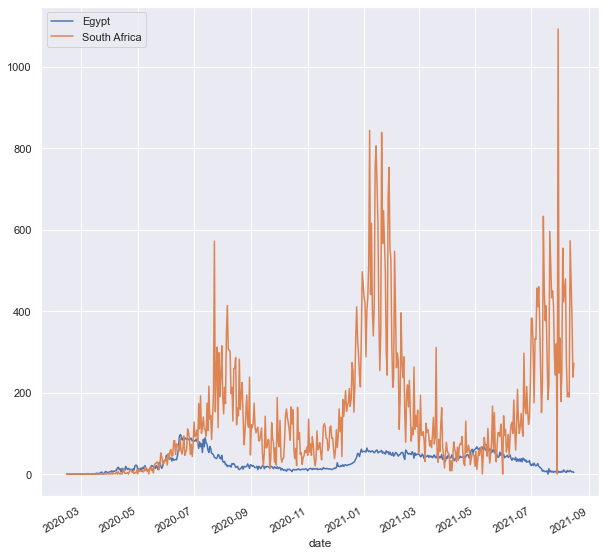

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
egy_sa = full_table.loc[['Egypt', 'South Africa']].reset_index().drop('state', axis=1)
egy_sa = egy_sa.pivot_table('deaths', index='date', columns=['country'])
egy_sa = egy_sa.fillna(method='bfill')
egy_sa['Egypt'].plot(ax=ax, label = 'Egypt')
egy_sa['South Africa'].plot(ax=ax, label= 'South Africa')
ax.legend();

In [14]:
full_wom_country[full_wom_country['continent'] == 'Europe'].drop('continent', axis=1).\
    sort_values('confirmed', ascending=False).style\
    .format('{:12,.0f}', subset=full_wom_country.columns[2:], na_rep='-')\
    .background_gradient(cmap='Greens', subset=full_wom_country.columns[2:])\
    .hide_index()
    

country,confirmed,deaths,recovered,active,tests,population
Russia,"6,621,601","171,305","5,899,917","550,379","172,500,000","146,004,820"
France,"6,476,864","112,753","5,913,362","450,749","111,773,788","65,435,866"
UK,"6,295,613","130,979","4,856,841","1,307,793","257,623,937","68,286,659"
Spain,"4,719,266","82,595","3,986,567","650,104","59,650,532","46,775,140"
Italy,"4,444,338","128,456","4,187,186","128,696","80,680,924","60,361,835"
Germany,"3,831,806","92,384","3,684,700","54,722","67,658,074","84,085,033"
Poland,"2,885,461","75,299","2,655,441","154,721","19,206,941","37,799,994"
Ukraine,"2,266,329","53,269","2,197,075","15,985","11,677,835","43,438,073"
Netherlands,"1,904,128","17,915","1,770,520","115,693","16,254,958","17,177,489"
Czechia,"1,676,297","30,375","1,643,596","2,326","34,589,960","10,731,314"


In [15]:
vic = full_table.loc[('Australia', 'Victoria')]
vic.tail(10)

,continent,confirmed,deaths,recovered,active,tests
date,,,,,,
2021-08-07,Others,30.0,0.0,0.0,0.0,NaN
2021-08-08,Others,13.0,0.0,0.0,0.0,NaN
2021-08-09,Others,11.0,0.0,0.0,0.0,NaN
2021-08-10,Others,20.0,0.0,0.0,0.0,NaN
2021-08-11,Others,20.0,0.0,0.0,0.0,NaN
2021-08-12,Others,18.0,0.0,0.0,0.0,NaN
2021-08-13,Others,19.0,0.0,0.0,0.0,NaN
2021-08-14,Others,21.0,0.0,0.0,0.0,NaN
2021-08-15,Others,25.0,0.0,0.0,0.0,NaN


<h3> India </h3>

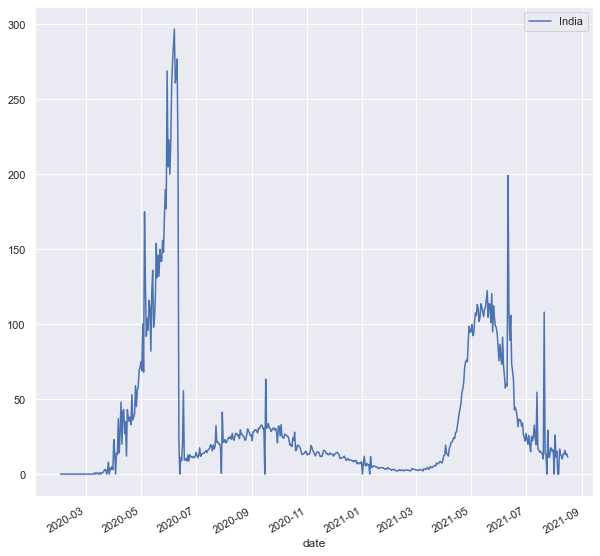

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
india = full_table.loc[['India']].reset_index().drop('state', axis=1)
india = india.pivot_table('deaths', index='date', columns=['country'])
india = india.fillna(method='bfill')
india['India'].plot(ax=ax, label = 'India')
ax.legend();